In [343]:
import numpy as np
import itertools
from scipy.special import comb
from scipy.linalg import subspace_angles
from scipy.optimize import minimize
from sklearn.cluster import SpectralClustering
import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
import cv2
from keras.datasets import cifar10

In [6]:
def single_cPCA(X:np.ndarray, Y:np.ndarray, alpha, k):
    Cx = np.cov(X.T)
    Cy = np.cov(Y.T)

    C = Cx - alpha * Cy
    _, V = np.linalg.eigh(C)

    return V[:, -k:]

In [99]:
def affinity(combination, d, k):
    combination = combination.reshape(2, d, k)
    return np.prod(np.cos(subspace_angles(*combination)))

def v_affinity(combinations, d, k):
    return np.apply_along_axis(lambda combination: affinity(combination, d, k), 1, combinations)

In [97]:
def cPCA(X:np.ndarray, Y:np.ndarray, alpha_set, k, p):
    # check d value:
    assert X.shape[1] == Y.shape[1]

    d = X.shape[1]
    V_set = []

    # calculate cPCA for each alpha
    for alpha in alpha_set:
        V = single_cPCA(X, Y, alpha, k)
        V_set.append(V)
    V_set = np.array(V_set)

    # calculate affinity Matrix for each pair of Vs
    combination_indices = np.array(list(itertools.combinations_with_replacement(range(len(V_set)), 2)))
    combinations = V_set[combination_indices].reshape(len(combination_indices), 2 * d * k)
    aff = v_affinity(combinations, d, k)

    rows = combination_indices[:, 0]
    cols = combination_indices[:, 1]
    D = np.zeros((len(V_set), len(V_set)))
    D[rows, cols] = D[cols, rows] = aff

    # cluster Vs with respect to affinities
    clustering = SpectralClustering(n_clusters=p, affinity='precomputed').fit(D)

    # find best V and alpha in each cluster
    V_star = np.zeros((p, d, k))
    alpha_star = np.zeros(p)
    for cluster in range(p):
        cluster_members = np.where(clustering.labels_ == cluster)[0]
        sums = np.sum(D[cluster_members, :][:, cluster_members], axis=1)
        V_star[cluster] = V_set[cluster_members[np.argmax(sums)]]
        alpha_star[cluster] = alpha_set[cluster_members[np.argmax(sums)]]
    
    return alpha_star, V_star

In [296]:
n = 1000
m = 100
d = 50
k = 20
p = 2

In [297]:
X = np.random.uniform(-10, 10, (n, d))
X.shape

(1000, 50)

In [298]:
Y = np.random.uniform(-10, 10, (m, d))
Y.shape

(100, 50)

In [302]:
alpha_set = np.arange(0.01, 1, 0.03)
alpha_set.shape

(33,)

In [306]:
alpha_star, V_star = cPCA(X, Y, alpha_set, k, p)

In [307]:
V_star.shape

(2, 50, 20)

In [308]:
alpha_star.shape

(2,)

Dataset description is available [here](https://archive.ics.uci.edu/ml/datasets/Mice+Protein+Expression).

In [362]:
dataset = pd.read_excel('https://archive.ics.uci.edu/ml/machine-learning-databases/00342/Data_Cortex_Nuclear.xls')
dataset.head()

,MouseID,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,pELK_N,pERK_N,pJNK_N,PKCA_N,pMEK_N,pNR1_N,pNR2A_N,pNR2B_N,pPKCAB_N,pRSK_N,AKT_N,BRAF_N,CAMKII_N,CREB_N,ELK_N,ERK_N,GSK3B_N,JNK_N,MEK_N,TRKA_N,RSK_N,APP_N,Bcatenin_N,SOD1_N,MTOR_N,P38_N,pMTOR_N,DSCR1_N,AMPKA_N,NR2B_N,...,TIAM1_N,pP70S6_N,NUMB_N,P70S6_N,pGSK3B_N,pPKCG_N,CDK5_N,S6_N,ADARB1_N,AcetylH3K9_N,RRP1_N,BAX_N,ARC_N,ERBB4_N,nNOS_N,Tau_N,GFAP_N,GluR3_N,GluR4_N,IL1B_N,P3525_N,pCASP9_N,PSD95_N,SNCA_N,Ubiquitin_N,pGSK3B_Tyr216_N,SHH_N,BAD_N,BCL2_N,pS6_N,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N,Genotype,Treatment,Behavior,class
0,309_1,0.503644,0.747193,0.430175,2.816329,5.990152,0.218830,0.177565,2.373744,0.232224,1.750936,0.687906,0.306382,0.402698,0.296927,1.022060,0.605673,1.877684,2.308745,0.441599,0.859366,0.416289,0.369608,0.178944,1.866358,3.685247,1.537227,0.264526,0.319677,0.813866,0.165846,0.453910,3.037621,0.369510,0.458539,0.335336,0.825192,0.576916,0.448099,0.586271,...,0.482864,0.294170,0.182150,0.842725,0.192608,1.443091,0.294700,0.354605,1.339070,0.170119,0.159102,0.188852,0.106305,0.144989,0.176668,0.125190,0.115291,0.228043,0.142756,0.430957,0.247538,1.603310,2.014875,0.108234,1.044979,0.831557,0.188852,0.122652,NaN,0.106305,0.108336,0.427099,0.114783,0.131790,0.128186,1.675652,Control,Memantine,C/S,c-CS-m
1,309_2,0.514617,0.689064,0.411770,2.789514,5.685038,0.211636,0.172817,2.292150,0.226972,1.596377,0.695006,0.299051,0.385987,0.281319,0.956676,0.587559,1.725774,2.043037,0.445222,0.834659,0.400364,0.356178,0.173680,1.761047,3.485287,1.509249,0.255727,0.304419,0.780504,0.157194,0.430940,2.921882,0.342279,0.423560,0.324835,0.761718,0.545097,0.420876,0.545097,...,0.454519,0.276431,0.182086,0.847615,0.194815,1.439460,0.294060,0.354548,1.306323,0.171427,0.158129,0.184570,0.106592,0.150471,0.178309,0.134275,0.118235,0.238073,0.142037,0.457156,0.257632,1.671738,2.004605,0.109749,1.009883,0.849270,0.200404,0.116682,NaN,0.106592,0.104315,0.441581,0.111974,0.135103,0.131119,1.743610,Control,Memantine,C/S,c-CS-m
2,309_3,0.509183,0.730247,0.418309,2.687201,5.622059,0.209011,0.175722,2.283337,0.230247,1.561316,0.677348,0.291276,0.381002,0.281710,1.003635,0.602449,1.731873,2.017984,0.467668,0.814329,0.399847,0.368089,0.173905,1.765544,3.571456,1.501244,0.259614,0.311747,0.785154,0.160895,0.423187,2.944136,0.343696,0.425005,0.324852,0.757031,0.543620,0.404630,0.552994,...,0.447197,0.256648,0.184388,0.856166,0.200737,1.524364,0.301881,0.386087,1.279600,0.185456,0.148696,0.190532,0.108303,0.145330,0.176213,0.132560,0.117760,0.244817,0.142445,0.510472,0.255343,1.663550,2.016831,0.108196,0.996848,0.846709,0.193685,0.118508,NaN,0.108303,0.106219,0.435777,0.111883,0.133362,0.127431,1.926427,Control,Memantine,C/S,c-CS-m
3,309_4,0.442107,0.617076,0.358626,2.466947,4.979503,0.222886,0.176463,2.152301,0.207004,1.595086,0.583277,0.296729,0.377087,0.313832,0.875390,0.520293,1.566852,2.132754,0.477671,0.727705,0.385639,0.362970,0.179449,1.286277,2.970137,1.419710,0.259536,0.279218,0.734492,0.162210,0.410615,2.500204,0.344509,0.429211,0.330121,0.746980,0.546763,0.386860,0.547849,...,0.442650,0.398534,0.161768,0.760234,0.184169,1.612382,0.296382,0.290680,1.198765,0.159799,0.166112,0.185323,0.103184,0.140656,0.163804,0.123210,0.117439,0.234947,0.145068,0.430996,0.251103,1.484624,1.957233,0.119883,0.990225,0.833277,0.192112,0.132781,NaN,0.103184,0.111262,0.391691,0.130405,0.147444,0.146901,1.700563,Control,Memantine,C/S,c-CS-m
4,309_5,0.434940,0.617430,0.358802,2.365785,4.718679,0.213106,0.173627,2.134014,0.192158,1.504230,0.550960,0.286961,0.363502,0.277964,0.864912,0.507990,1.480059,2.013697,0.483416,0.687794,0.367531,0.355311,0.174836,1.324695,2.896334,1.359876,0.250705,0.273667,0.702699,0.154827,0.398550,2.456560,0.329126,0.408755,0.313415,0.691956,0.536860,0.360816,0.512824,...,0.419095,0.393447,0.160200,0.768113,0.185718,1.645807,0.296829,0.309345,1.206995,0.164650,0.160687,0.188221,0.104784,0.141983,0.167710,0.136838,0.116048,0.255528,0.140871,0.48

In [16]:
dataset.Genotype.unique()

array(['Control', 'Ts65Dn'], dtype=object)

In [17]:
dataset.Treatment.unique()

array(['Memantine', 'Saline'], dtype=object)

In [15]:
dataset.Behavior.unique()

array(['C/S', 'S/C'], dtype=object)

In [363]:
missing_cols = dataset.columns[dataset.isnull().any()]
missing_cols.size

49

In [364]:
for col in missing_cols:

    missing_data = len(dataset[dataset[col].isnull()].index)

    print(f'column {col}: {missing_data} missing values')

    imputer = IterativeImputer(random_state=10)
    dataset[col] = imputer.fit_transform(dataset[col].values.reshape(len(dataset.index), 1))

column DYRK1A_N: 3 missing values
column ITSN1_N: 3 missing values
column BDNF_N: 3 missing values
column NR1_N: 3 missing values
column NR2A_N: 3 missing values
column pAKT_N: 3 missing values
column pBRAF_N: 3 missing values
column pCAMKII_N: 3 missing values
column pCREB_N: 3 missing values
column pELK_N: 3 missing values
column pERK_N: 3 missing values
column pJNK_N: 3 missing values
column PKCA_N: 3 missing values
column pMEK_N: 3 missing values
column pNR1_N: 3 missing values
column pNR2A_N: 3 missing values
column pNR2B_N: 3 missing values
column pPKCAB_N: 3 missing values
column pRSK_N: 3 missing values
column AKT_N: 3 missing values
column BRAF_N: 3 missing values
column CAMKII_N: 3 missing values
column CREB_N: 3 missing values
column ELK_N: 18 missing values
column ERK_N: 3 missing values
column GSK3B_N: 3 missing values
column JNK_N: 3 missing values
column MEK_N: 7 missing values
column TRKA_N: 3 missing values
column RSK_N: 3 missing values
column APP_N: 3 missing values


In [365]:
dataset.columns[dataset.isnull().any()].size

0

In [366]:
control = dataset[dataset.Genotype == 'Control']
control.head()

,MouseID,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,pELK_N,pERK_N,pJNK_N,PKCA_N,pMEK_N,pNR1_N,pNR2A_N,pNR2B_N,pPKCAB_N,pRSK_N,AKT_N,BRAF_N,CAMKII_N,CREB_N,ELK_N,ERK_N,GSK3B_N,JNK_N,MEK_N,TRKA_N,RSK_N,APP_N,Bcatenin_N,SOD1_N,MTOR_N,P38_N,pMTOR_N,DSCR1_N,AMPKA_N,NR2B_N,...,TIAM1_N,pP70S6_N,NUMB_N,P70S6_N,pGSK3B_N,pPKCG_N,CDK5_N,S6_N,ADARB1_N,AcetylH3K9_N,RRP1_N,BAX_N,ARC_N,ERBB4_N,nNOS_N,Tau_N,GFAP_N,GluR3_N,GluR4_N,IL1B_N,P3525_N,pCASP9_N,PSD95_N,SNCA_N,Ubiquitin_N,pGSK3B_Tyr216_N,SHH_N,BAD_N,BCL2_N,pS6_N,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N,Genotype,Treatment,Behavior,class
0,309_1,0.503644,0.747193,0.430175,2.816329,5.990152,0.218830,0.177565,2.373744,0.232224,1.750936,0.687906,0.306382,0.402698,0.296927,1.022060,0.605673,1.877684,2.308745,0.441599,0.859366,0.416289,0.369608,0.178944,1.866358,3.685247,1.537227,0.264526,0.319677,0.813866,0.165846,0.453910,3.037621,0.369510,0.458539,0.335336,0.825192,0.576916,0.448099,0.586271,...,0.482864,0.294170,0.182150,0.842725,0.192608,1.443091,0.294700,0.354605,1.339070,0.170119,0.159102,0.188852,0.106305,0.144989,0.176668,0.125190,0.115291,0.228043,0.142756,0.430957,0.247538,1.603310,2.014875,0.108234,1.044979,0.831557,0.188852,0.122652,0.134762,0.106305,0.108336,0.427099,0.114783,0.131790,0.128186,1.675652,Control,Memantine,C/S,c-CS-m
1,309_2,0.514617,0.689064,0.411770,2.789514,5.685038,0.211636,0.172817,2.292150,0.226972,1.596377,0.695006,0.299051,0.385987,0.281319,0.956676,0.587559,1.725774,2.043037,0.445222,0.834659,0.400364,0.356178,0.173680,1.761047,3.485287,1.509249,0.255727,0.304419,0.780504,0.157194,0.430940,2.921882,0.342279,0.423560,0.324835,0.761718,0.545097,0.420876,0.545097,...,0.454519,0.276431,0.182086,0.847615,0.194815,1.439460,0.294060,0.354548,1.306323,0.171427,0.158129,0.184570,0.106592,0.150471,0.178309,0.134275,0.118235,0.238073,0.142037,0.457156,0.257632,1.671738,2.004605,0.109749,1.009883,0.849270,0.200404,0.116682,0.134762,0.106592,0.104315,0.441581,0.111974,0.135103,0.131119,1.743610,Control,Memantine,C/S,c-CS-m
2,309_3,0.509183,0.730247,0.418309,2.687201,5.622059,0.209011,0.175722,2.283337,0.230247,1.561316,0.677348,0.291276,0.381002,0.281710,1.003635,0.602449,1.731873,2.017984,0.467668,0.814329,0.399847,0.368089,0.173905,1.765544,3.571456,1.501244,0.259614,0.311747,0.785154,0.160895,0.423187,2.944136,0.343696,0.425005,0.324852,0.757031,0.543620,0.404630,0.552994,...,0.447197,0.256648,0.184388,0.856166,0.200737,1.524364,0.301881,0.386087,1.279600,0.185456,0.148696,0.190532,0.108303,0.145330,0.176213,0.132560,0.117760,0.244817,0.142445,0.510472,0.255343,1.663550,2.016831,0.108196,0.996848,0.846709,0.193685,0.118508,0.134762,0.108303,0.106219,0.435777,0.111883,0.133362,0.127431,1.926427,Control,Memantine,C/S,c-CS-m
3,309_4,0.442107,0.617076,0.358626,2.466947,4.979503,0.222886,0.176463,2.152301,0.207004,1.595086,0.583277,0.296729,0.377087,0.313832,0.875390,0.520293,1.566852,2.132754,0.477671,0.727705,0.385639,0.362970,0.179449,1.286277,2.970137,1.419710,0.259536,0.279218,0.734492,0.162210,0.410615,2.500204,0.344509,0.429211,0.330121,0.746980,0.546763,0.386860,0.547849,...,0.442650,0.398534,0.161768,0.760234,0.184169,1.612382,0.296382,0.290680,1.198765,0.159799,0.166112,0.185323,0.103184,0.140656,0.163804,0.123210,0.117439,0.234947,0.145068,0.430996,0.251103,1.484624,1.957233,0.119883,0.990225,0.833277,0.192112,0.132781,0.134762,0.103184,0.111262,0.391691,0.130405,0.147444,0.146901,1.700563,Control,Memantine,C/S,c-CS-m
4,309_5,0.434940,0.617430,0.358802,2.365785,4.718679,0.213106,0.173627,2.134014,0.192158,1.504230,0.550960,0.286961,0.363502,0.277964,0.864912,0.507990,1.480059,2.013697,0.483416,0.687794,0.367531,0.355311,0.174836,1.324695,2.896334,1.359876,0.250705,0.273667,0.702699,0.154827,0.398550,2.456560,0.329126,0.408755,0.313415,0.691956,0.536860,0.360816,0.512824,...,0.419095,0.393447,0.160200,0.768113,0.185718,1.645807,0.296829,0.309345,1.206995,0.164650,0.160687,0.188221,0.104784,0.141983,0.167710,0.136838,0.116048,0.

In [371]:
trisomic = dataset[dataset.Genotype == 'Ts65Dn']
trisomic.shape

(510, 82)

In [370]:
background_dataset = control[:(len(control.index) // 2)]
background_dataset.shape

(285, 82)

In [374]:
target_dataset = pd.concat([control[(len(control.index) // 2):], trisomic[:(len(trisomic.index) // 2)]])
target_dataset.shape

(540, 82)

In [375]:
Y = background_dataset.drop(['Genotype', 'MouseID', 'Treatment', 'class', 'Behavior'] , axis=1).values
Y.shape

(285, 77)

In [376]:
X = target_dataset.drop(['Genotype', 'MouseID', 'Treatment', 'class', 'Behavior'] , axis=1).values
X.shape

(540, 77)

In [521]:
from contrastive import CPCA


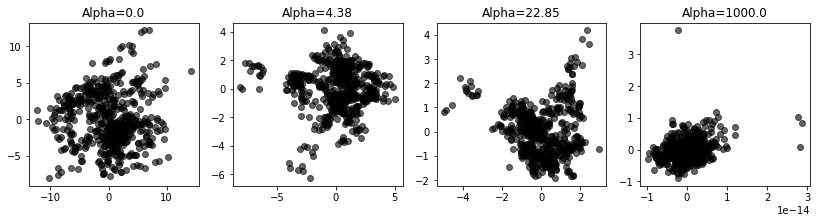

In [531]:
X_transformed = CPCA().fit_transform(X, Y, plot=True)

In [513]:
alpha_set = np.arange(330, 350, 0.1)
alpha_set.size

200

In [514]:
alpha_star, V_star = cPCA(X, Y, alpha_set, k=2, p=1)

In [515]:
alpha_star[0]

339.7000000000022

In [516]:
V_star[0].shape

(77, 2)

In [517]:
X_transformed = X.dot(V_star[0])
X_transformed.shape

(540, 2)

In [537]:
V = single_cPCA(X, Y, 0, 2)
V.shape

(77, 2)

In [538]:
X_transformed = X.dot(V)
X_transformed.shape

(540, 2)

In [539]:
transformed_data = pd.DataFrame(X_transformed, columns=['x', 'y'])
transformed_data['label'] = (target_dataset.Genotype.values == 'Ts65Dn')
transformed_data.head()

,x,y,label
0,-0.309049,-9.350965,False
1,-0.244696,-9.478299,False
2,-0.193148,-9.453008,False
3,-0.417345,-8.698054,False
4,-0.443446,-8.591562,False


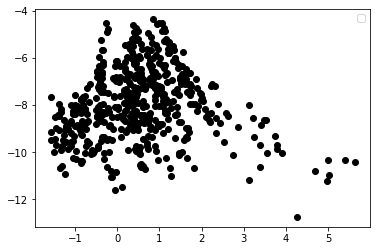

In [541]:
plt.figure()
plt.scatter(transformed_data.x, transformed_data.y, c=transformed_data.label)
plt.legend()

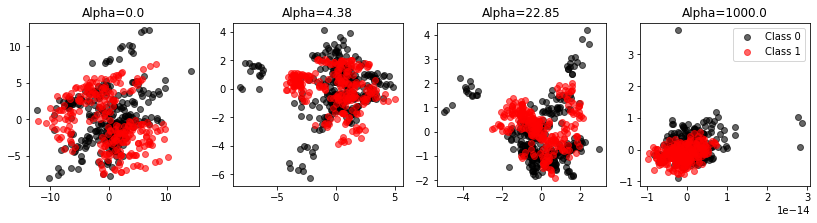

In [548]:
X_transformed = CPCA().fit_transform(X, Y, plot=True, active_labels=transformed_data.label)

In [550]:
N = 400; D = 30; gap=3
# In B, all the data pts are from the same distribution, which has different variances in three subspaces.
B = np.zeros((N, D))
B[:,0:10] = np.random.normal(0,10,(N,10))
B[:,10:20] = np.random.normal(0,3,(N,10))
B[:,20:30] = np.random.normal(0,1,(N,10))


# In A there are four clusters.
A = np.zeros((N, D))
A[:,0:10] = np.random.normal(0,10,(N,10))
# group 1
A[0:100, 10:20] = np.random.normal(0,1,(100,10))
A[0:100, 20:30] = np.random.normal(0,1,(100,10))
# group 2
A[100:200, 10:20] = np.random.normal(0,1,(100,10))
A[100:200, 20:30] = np.random.normal(gap,1,(100,10))
# group 3
A[200:300, 10:20] = np.random.normal(2*gap,1,(100,10))
A[200:300, 20:30] = np.random.normal(0,1,(100,10))
# group 4
A[300:400, 10:20] = np.random.normal(2*gap,1,(100,10))
A[300:400, 20:30] = np.random.normal(gap,1,(100,10))
A_labels = [0]*100+[1]*100+[2]*100+[3]*100

In [551]:
pca = PCA(n_components=2)

In [552]:
pca_transformed = pca.fit_transform(A)

In [553]:
pca_transformed_data = pd.DataFrame(pca_transformed, columns=['x', 'y'])
pca_transformed_data['label'] = A_labels
pca_transformed_data.head()

,x,y,label
0,-6.171492,6.540086,0
1,8.718105,-4.118884,0
2,-17.480327,-5.307482,0
3,-5.259095,8.531249,0
4,4.686989,17.901805,0


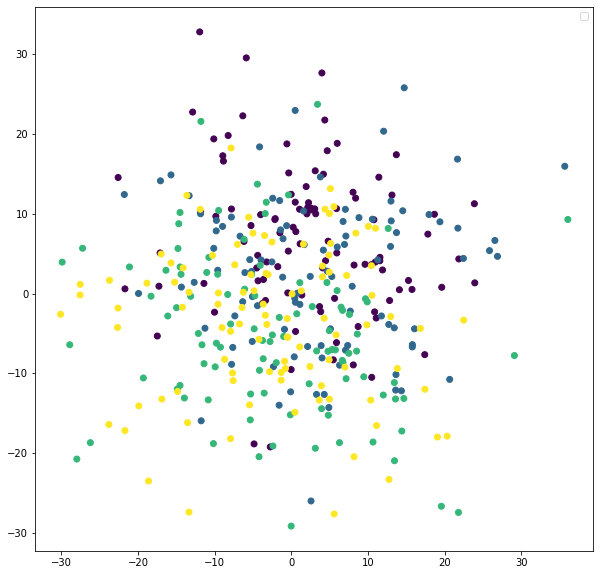

In [554]:
plt.figure(figsize=(10, 10))
plt.scatter(pca_transformed_data.x, pca_transformed_data.y, c=pca_transformed_data.label)
plt.legend()

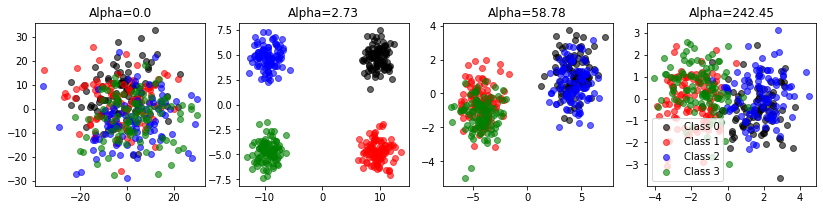

In [555]:
CPCA(standardize=False).fit_transform(A, B, plot=True, active_labels=A_labels)

In [556]:
V = single_cPCA(A, B, 2.73, 2)
V.shape

(30, 2)

In [558]:
X_transformed = A.dot(V)
X_transformed.shape

(400, 2)

In [559]:
transformed_data = pd.DataFrame(X_transformed, columns=['x', 'y'])
transformed_data['label'] = A_labels
transformed_data.head()

,x,y,label
0,-1.525140,-0.935216,0
1,-0.608878,-0.256605,0
2,-0.118935,1.418882,0
3,-0.510957,-1.968073,0
4,-0.133500,-1.154487,0


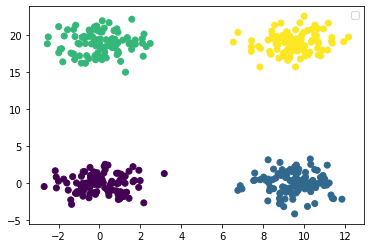

In [560]:
plt.figure()
plt.scatter(transformed_data.x, transformed_data.y, c=transformed_data.label)
plt.legend()

In [191]:
mnist = fetch_openml('mnist_784')

In [201]:
zero_one_data = mnist.data[(mnist.target == '0') | (mnist.target == '1')] / 255
zero_one_target = mnist.target[(mnist.target == '0') | (mnist.target == '1')]

In [202]:
zero_one_data.shape

(14780, 784)

In [203]:
zero_one_target.shape

(14780,)

In [344]:
(cifar_images, cifar_labels), (_, _) = cifar10.load_data()

170500096/170498071 [==============================] - 11s 0us/step


In [347]:
cifar_images.shape

(50000, 32, 32, 3)

In [349]:
gray = cifar_images.mean(axis=3)
gray.shape

(50000, 32, 32)

In [356]:
gray_resized = np.zeros((50000, 28, 28))

In [357]:
def resize(index):
    gray_resized[index] = cv2.resize(gray[index], dsize=(28, 28), interpolation=cv2.INTER_CUBIC)

In [358]:
np.vectorize(resize)(np.arange(len(gray)))

array([None, None, None, ..., None, None, None], dtype=object)

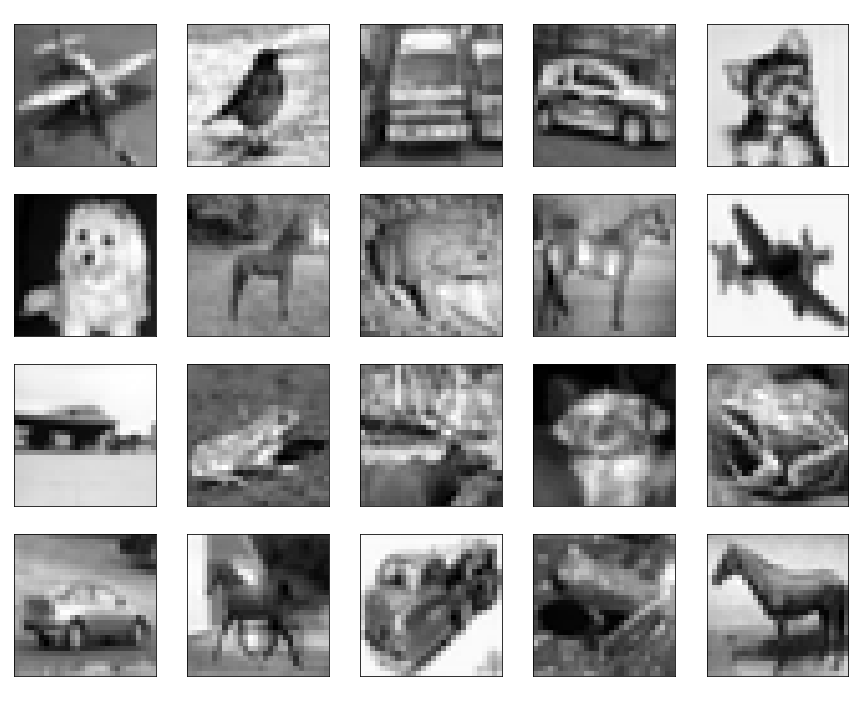

In [361]:
images = gray_resized[np.random.choice(np.arange(len(gray_resized)), size=20)]
draw(images, columns=5, rows=4)

In [ ]:
images = X[np.random.choice(np.arange(len(X)), size=20)]
draw(images, columns=5, rows=4)

In [275]:
noises = np.random.randn(*zero_one_data.shape)

In [340]:
X = np.clip(zero_one_data * noises, 0, 1)

In [334]:
X.shape

(14780, 784)

In [360]:
def draw(images, texts=None, columns=1, rows=1):
    fig = plt.figure(figsize=(3 * columns, 3 * rows))

    for i in range(columns * rows):
        ax = fig.add_subplot(rows, columns, i + 1)
        if texts is not None:
            ax.set_title(texts[i])
        ax.set_aspect('equal')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.imshow(images[i].reshape(28, 28) * 255, cmap='gray')

    cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
    cax.get_xaxis().set_visible(False)
    cax.get_yaxis().set_visible(False)
    cax.set_frame_on(False)
    plt.show()

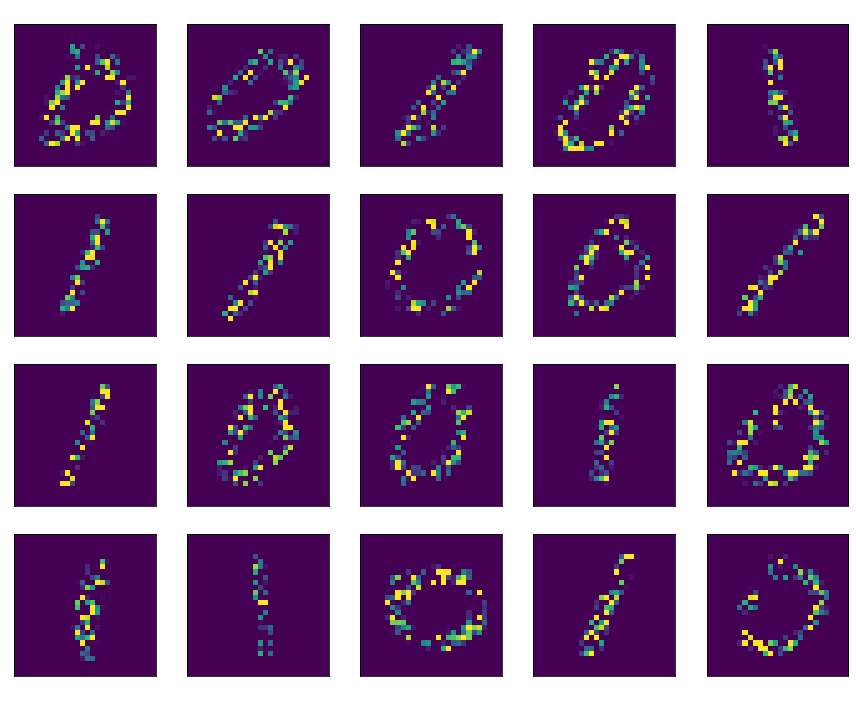

In [341]:
images = X[np.random.choice(np.arange(len(X)), size=20)]
draw(images, columns=5, rows=4)

In [314]:
Y = np.clip(np.matmul(X.reshape(14780, 28, 28), noises.reshape(14780, 28, 28)), 0, 1).reshape(zero_one_data.shape)
Y.shape

(14780, 784)

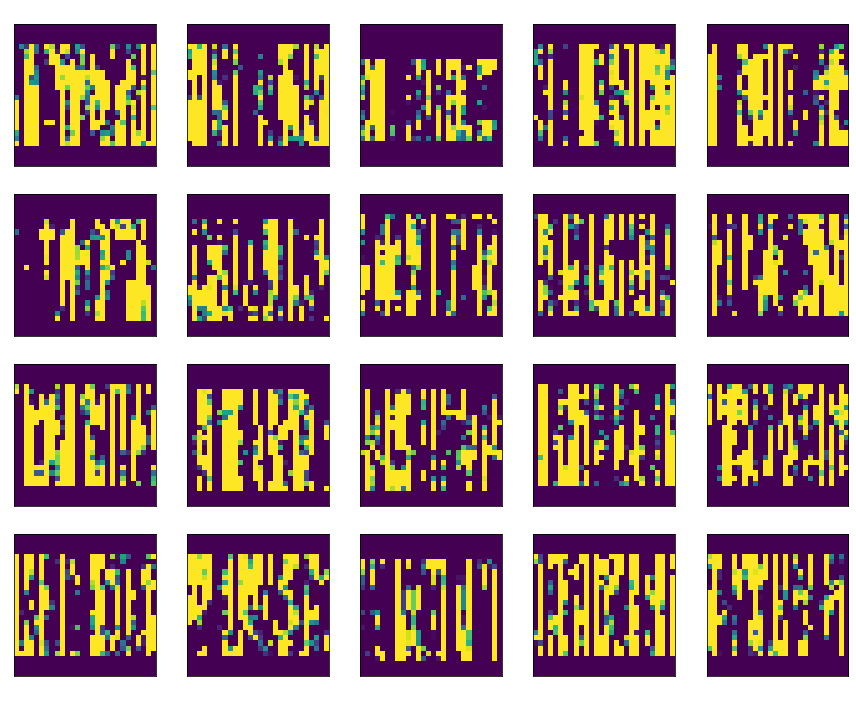

In [315]:
images = Y[np.random.choice(np.arange(len(Y)), size=20)]
draw(images, columns=5, rows=4)

In [316]:
alpha_set = np.arange(240, 250, 1)
alpha_set.size

10

In [317]:
alpha_star, V_star = cPCA(X, noises, alpha_set, k=2, p=1)

In [318]:
alpha_star[0]

244.0

In [319]:
X_transformed = X.dot(V_star[0])
X_transformed.shape

(14780, 2)

In [320]:
transformed_data = pd.DataFrame(X_transformed, columns=['x', 'y'])
transformed_data['label'] = ('10' + zero_one_target).astype('int32')
transformed_data.head()

,x,y,label
0,-0.457798,-0.430573,100
1,0.155218,0.022121,101
2,-0.641839,0.034357,101
3,-0.523898,0.326141,101
4,0.121033,0.841715,101


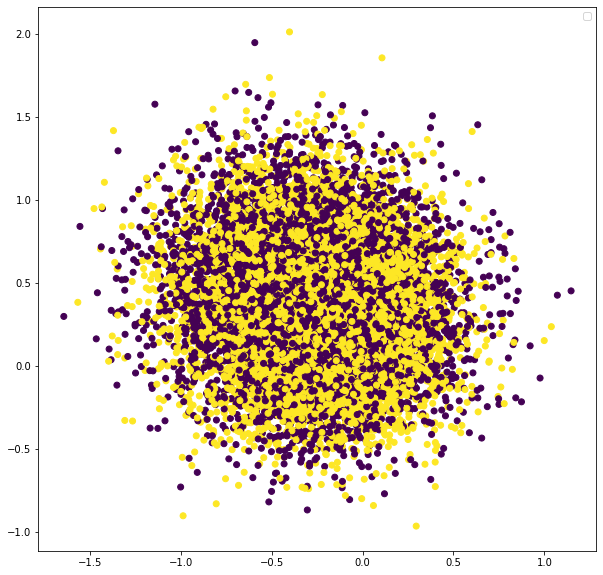

In [321]:
plt.figure(figsize=(10, 10))
plt.scatter(transformed_data.x, transformed_data.y, c=transformed_data.label)
plt.legend()

In [249]:
sum(transformed_data.label == '0')

6903

In [336]:
pca = PCA(n_components=2)

In [337]:
pca_transformed = pca.fit_transform(X)

In [338]:
pca_transformed_data = pd.DataFrame(pca_transformed, columns=['x', 'y'])
pca_transformed_data['label'] = ('10' + zero_one_target).astype('int32')
pca_transformed_data.head()

,x,y,label
0,2.839720,0.382414,100
1,-1.657162,1.484919,101
2,-1.826175,-2.205766,101
3,-1.784808,-2.052269,101
4,-2.179541,-1.898359,101


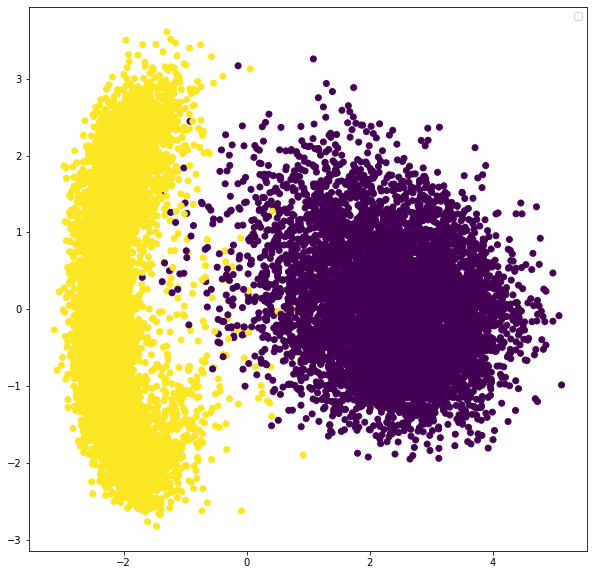

In [339]:
plt.figure(figsize=(10, 10))
plt.scatter(pca_transformed_data.x, pca_transformed_data.y, c=pca_transformed_data.label)
plt.legend()